<h2>1.資料介紹</h2>

1.offering.txt 飯店基本資料:      
id:飯店ID(主key)  
name:飯店名稱  
hotel_class:飯店星等 (每0.5為單位，0~5星,<font color="red">這並非所有資料都有星等</font>)   
address: 包含街道、郵遞區號、城市等  
region_id: 所屬地區  
url: TripAdvisor 網址  
其他欄位如 details、phone 等 可能為空值  

2.review.txt 使用者評論資料:  
text: 評論內容  
ratings: 各項評分（overall, service, rooms, cleanliness, ...）  
title: 評論標題 
date, date_stayed: 留言與入住日期   
offering_id: forign key to 'id' in offering.txt   
author: 評論者資訊  

## 資料載入與前處理（結合 review + offering 資料）
- 過濾掉 hotel_class 為空值的資料
- 合併資料集

In [ ]:


import pandas as pd
import ast
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_predict, cross_validate
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

reviews = pd.read_csv("./raw_data/reviews.csv")
offerings = pd.read_csv("./raw_data/offerings.csv")
offerings = offerings[offerings['hotel_class'].notna()]
merged = reviews.merge(offerings, left_on='offering_id', right_on='id', suffixes=('_review', '_offering'))

print(merged.head(2))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                             ratings  \
0  {'service': 5.0, 'cleanliness': 5.0, 'overall'...   
1  {'service': 5.0, 'cleanliness': 5.0, 'overall'...   

                                       title  \
0  “Truly is "Jewel of the Upper Wets Side"”   
1                  “My home away from home!”   

                                                text  \
0  Stayed in a king suite for 11 nights and yes i...   
1  On every visit to NYC, the Hotel Beacon is the...   

                                              author    date_stayed  \
0  {'username': 'Papa_Panda', 'num_cities': 22, '...  December 2012   
1  {'username': 'Maureen V', 'num_reviews': 2, 'n...  December 2012   

   offering_id  num_helpful_votes        date  id_review  via_mobile  \
0        93338                  0  2012-12-17  147643103       False   
1        93338                  0  2012-12-17  147639004       False   

   hotel_class  region_id                                                url  \
0     

## 清理資料
- 詞幹正規化 & 停用字 & 小寫 & 單一字

In [46]:
merged['text'] = merged['text'].astype(str)
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-z ]', ' ', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word)>1]
    return ' '.join(tokens)

merged['clean_text'] = merged['text'].apply(preprocess)
# 檢視資料
print(f"總評論數: {merged.shape[0]}")
print(f"星級分佈:\n{merged['hotel_class'].value_counts()}")
#取出需要的欄位
merged = merged[['hotel_class', 'offering_id', 'clean_text']]


總評論數: 843624
星級分佈:
hotel_class
4.0    288492
3.0    173205
3.5    167315
2.5     69926
2.0     62547
4.5     46595
5.0     29192
1.5      4662
1.0      1690
Name: count, dtype: int64


### 準備資料
- 以 offering_id 為單位彙整所有評論文字

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# hotel_texts
hotel_texts = merged.groupby('offering_id')['clean_text'].apply(lambda x: ' '.join(x.dropna()))
# hotel_labels
hotel_labels = merged.groupby('offering_id')['hotel_class'].first()

X = hotel_texts.values
y = hotel_labels.astype(str).values

# 切分資料集：70% 訓練，30% 測試
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=36, stratify=y)

# 向量化訓練資料
# vectorizer = CountVectorizer(max_features=1000, stop_words='english')
# X_train = vectorizer.fit_transform(X_train_raw)
# X_test = vectorizer.transform(X_test_raw)
# 經比較後認為TfidfVectorizer 做交叉驗證來壓低常見詞會更好
vectorizer = TfidfVectorizer(max_features=3000, min_df=3, max_df=0.8, stop_words='english')

# 莘惠寫的
# 轉換訓練與測試資料
vec_train = vectorizer.fit_transform(X_train_raw)
vec_test = vectorizer.transform(X_test_raw)
# 檢視轉換後的矩陣形狀
print(f"訓練集矩陣形狀: {vec_train.shape}")
print(f"測試集矩陣形狀: {vec_test.shape}")


hotel_texts 筆數: 3119
hotel_labels 筆數: 3119
平均字數: 136814.65
最長評論字數: 2952777
最短評論字數: 100
訓練集矩陣形狀: (2183, 3000)
測試集矩陣形狀: (936, 3000)


In [32]:
# 定義訓練與交叉驗證函數
def train_cv(vectorizer, clf, X, y):
    vec_X = vectorizer.fit_transform(X) 
    cv_results = cross_validate(clf, vec_X, y, cv=5, return_estimator=True)
    y_pred = cross_val_predict(clf, vec_X, y, cv=5)
    
    # 輸出分類報告
    cls_report = classification_report(y, y_pred, output_dict=True)
    print(classification_report(y, y_pred))
    
    # 從交叉驗證的結果中提取類別
    classes = cv_results['estimator'][0].classes_
    cm = confusion_matrix(y, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(
        xlabel="預測星級",
        ylabel="真實星級",
        xticklabels=classes,
        yticklabels=classes,
        title=f"{str(clf)} 混淆矩陣"
    )
    plt.yticks(rotation=0)
    plt.show()
    
    clf.fit(vec_X, y)
    return cls_report


## 比較模型效能
- Logistic Regression、 Linear SVM、 Naive Bayes, Random Forest

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         8
         1.5       0.00      0.00      0.00        45
         2.0       0.69      0.86      0.76       522
         2.5       0.72      0.60      0.66       438
         3.0       0.66      0.75      0.70       522
         3.5       0.61      0.48      0.54       281
         4.0       0.60      0.73      0.66       274
         4.5       0.00      0.00      0.00        43
         5.0       1.00      0.36      0.53        50

    accuracy                           0.67      2183
   macro avg       0.47      0.42      0.43      2183
weighted avg       0.64      0.67      0.65      2183



c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

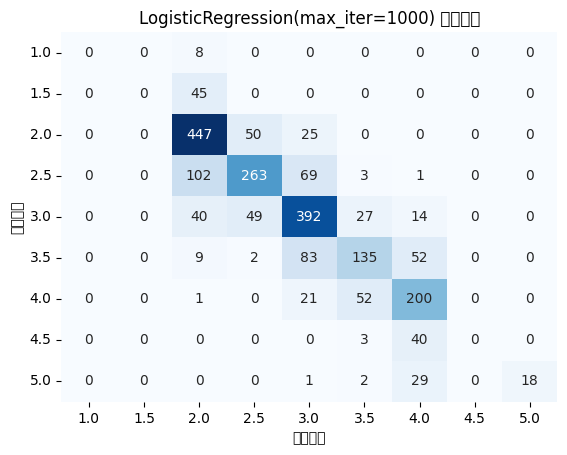

c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dua

              precision    recall  f1-score   support

         1.0       1.00      0.38      0.55         8
         1.5       0.00      0.00      0.00        45
         2.0       0.71      0.86      0.78       522
         2.5       0.70      0.61      0.65       438
         3.0       0.71      0.71      0.71       522
         3.5       0.61      0.57      0.59       281
         4.0       0.64      0.73      0.68       274
         4.5       0.40      0.19      0.25        43
         5.0       0.80      0.64      0.71        50

    accuracy                           0.68      2183
   macro avg       0.62      0.52      0.55      2183
weighted avg       0.67      0.68      0.67      2183



c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23526 (\N{CJK UNIFIED IDEOGRAPH-5BE6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26143 (\N{CJK UNIFIED IDEOGRAPH-661F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 32026 (\N{CJK UNIFIED IDEOGRAPH-7D1A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPyt

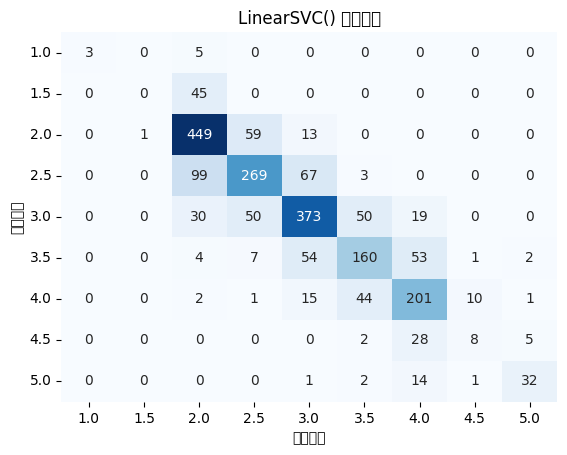

c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         8
         1.5       0.00      0.00      0.00        45
         2.0       0.68      0.78      0.72       522
         2.5       0.67      0.61      0.64       438
         3.0       0.50      0.70      0.58       522
         3.5       0.53      0.11      0.18       281
         4.0       0.47      0.66      0.55       274
         4.5       0.00      0.00      0.00        43
         5.0       0.00      0.00      0.00        50

    accuracy                           0.57      2183
   macro avg       0.32      0.32      0.30      2183
weighted avg       0.54      0.57      0.53      2183



c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

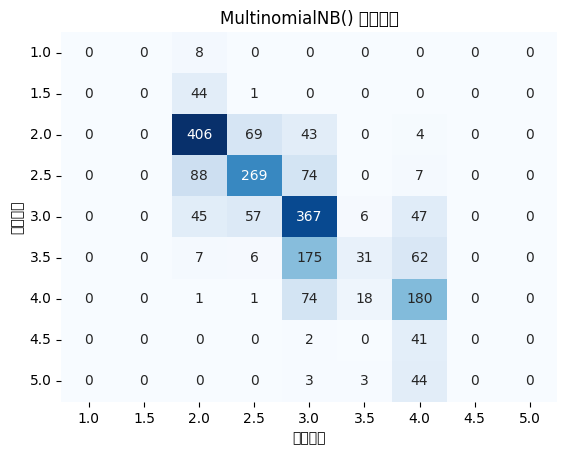

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         8
         1.5       0.00      0.00      0.00        45
         2.0       0.69      0.85      0.76       522
         2.5       0.67      0.56      0.61       438
         3.0       0.58      0.72      0.64       522
         3.5       0.50      0.31      0.39       281
         4.0       0.67      0.76      0.71       274
         4.5       0.00      0.00      0.00        43
         5.0       0.83      0.60      0.70        50

    accuracy                           0.64      2183
   macro avg       0.44      0.42      0.42      2183
weighted avg       0.61      0.64      0.61      2183



c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

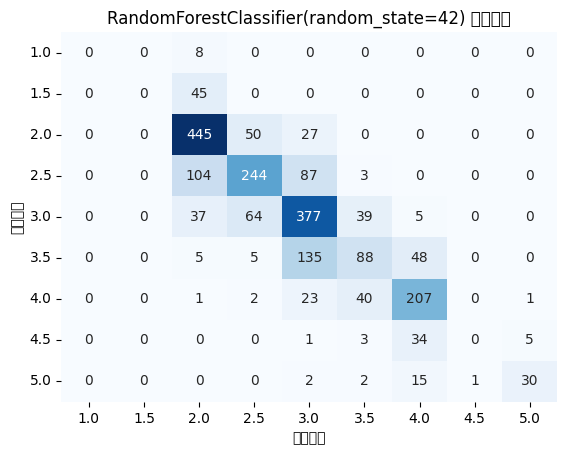

In [33]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
import time
# 比較模型效能
models = [
    ("Logistic Regression", LogisticRegression(max_iter=1000)),
    ("Linear SVM", LinearSVC()),
    ("Naive Bayes", MultinomialNB()),
    ("Random Forest", RandomForestClassifier(n_estimators=100, random_state=42))
]
t0 = time.time()
results = {}

# 改用 TfidfVectorizer 後的 train_cv
for name, clf in models:
#     print(f"\n===== Model: {name} =====")
#     clf.fit(X_train, y_train)
#     y_pred = clf.predict(X_test)

#     print(classification_report(y_test, y_pred))

#     cm = confusion_matrix(y_test, y_pred, labels=sorted(np.unique(y)))
#     fig, ax = plt.subplots()
#     sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=sorted(np.unique(y)), yticklabels=sorted(np.unique(y)))
#     ax.set_title(f"Confusion Matrix: {name}")
#     ax.set_xlabel("Predicted")
#     ax.set_ylabel("True")
#     plt.yticks(rotation=0)
#     plt.show()

#     results[name] = classification_report(y_test, y_pred, output_dict=True)
    results[name] = train_cv(vectorizer, clf, X_train_raw, y_train)

In [34]:
f1_scores = {
    name: report['weighted avg']['f1-score']
    for name, report in results.items()
}

# 找出 F1-score 最高的模型
best_model_name = max(f1_scores, key=f1_scores.get)
best_score = f1_scores[best_model_name]

print("=== 模型 F1-score 比較 weighted avg  ===")
for name, score in f1_scores.items():
    print(f"{name}: {score:.4f}")

print(f"\n✅ 最佳模型是：{best_model_name} F1-score = {best_score:.4f}")

print(f"花費時間: {time.time() - t0} sec")

=== 模型 F1-score 比較 weighted avg  ===
Logistic Regression: 0.6456
Linear SVM: 0.6724
Naive Bayes: 0.5330
Random Forest: 0.6127

✅ 最佳模型是：Linear SVM F1-score = 0.6724
花費時間: 176.75247883796692 sec


### 測試集預測表現
- Logistic Regression F1-score = 0.6797
- 測試 -> 儲存模型

In [35]:
# 多筆評論預測函式
# 向量化與模型訓練
# 同樣改成TfidfVectorizer
# vectorizer = CountVectorizer(max_features=1000, stop_words='english')
vectorizer = TfidfVectorizer(max_features=3000, min_df=3, max_df=0.8, stop_words='english')
vec_X = vectorizer.fit_transform(X_train_raw)

print(f"正在使用最佳模型訓練：{best_model_name}")
clf_final = next(model for name, model in models if name == best_model_name)
clf_final.fit(vec_X, y_train)

y_pred = clf_final.predict(vec_test)

# 輸出測試集分類報告
print(f"\n測試集結果 ({best_model_name}):\n")
print(classification_report(y_test, y_pred))

正在使用最佳模型訓練：Linear SVM


c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(



測試集結果 (Linear SVM):

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         4
         1.5       0.00      0.00      0.00        19
         2.0       0.73      0.85      0.78       224
         2.5       0.75      0.66      0.70       187
         3.0       0.72      0.74      0.73       223
         3.5       0.65      0.64      0.64       121
         4.0       0.66      0.76      0.71       118
         4.5       0.17      0.06      0.08        18
         5.0       0.81      0.59      0.68        22

    accuracy                           0.71       936
   macro avg       0.50      0.48      0.48       936
weighted avg       0.68      0.71      0.69       936



c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

### 解釋模型

- 其中幾個星級（1.0、1.5、4.5）幾乎無法預測，推測是訓練集裡的資料太少
- 每一個星級對應的影響詞彙
- 整體最有影響力的詞（不分星級）

c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif


=== Classification Report ===

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         4
         1.5       0.00      0.00      0.00        19
         2.0       0.73      0.85      0.78       224
         2.5       0.75      0.66      0.70       187
         3.0       0.72      0.74      0.73       223
         3.5       0.65      0.64      0.64       121
         4.0       0.66      0.76      0.71       118
         4.5       0.17      0.06      0.08        18
         5.0       0.81      0.59      0.68        22

    accuracy                           0.71       936
   macro avg       0.50      0.48      0.48       936
weighted avg       0.68      0.71      0.69       936



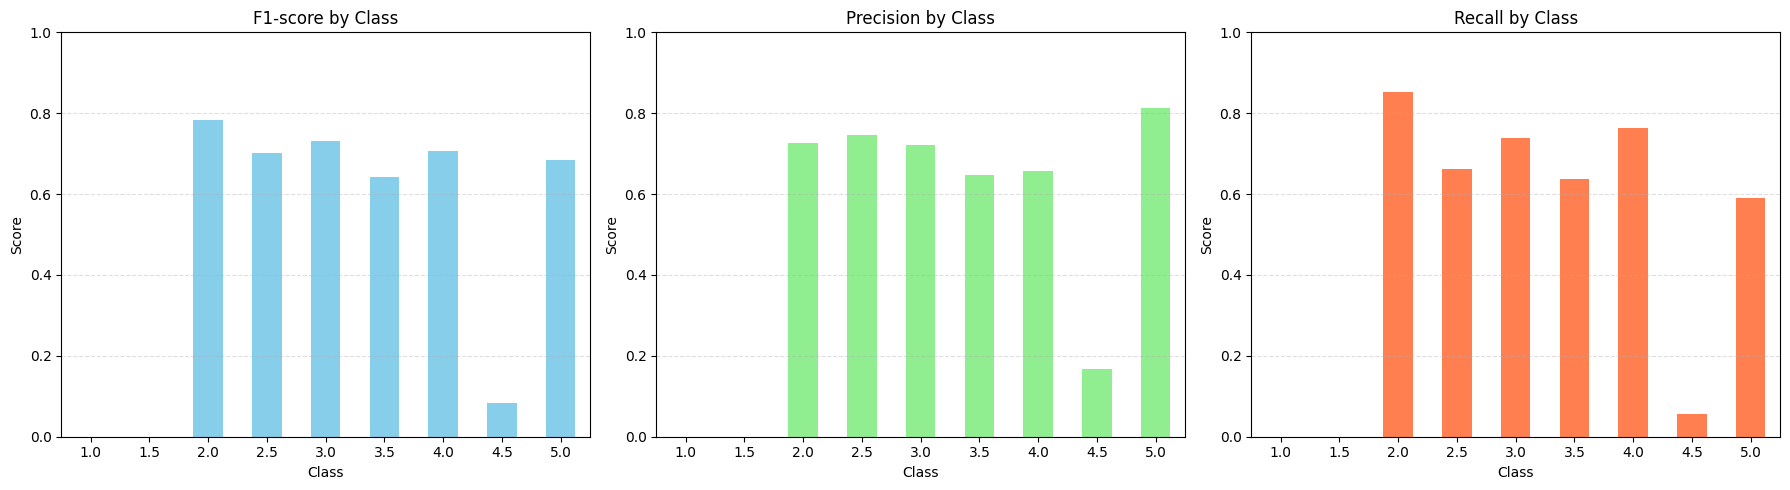

In [39]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

def plot_classification_report(y_test, y_pred):

    # 產出分類報告（dict 形式）
    report_dict = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report_dict).T

    # 顯示文字報告
    print("\n=== Classification Report ===\n")
    print(classification_report(y_test, y_pred))

    # 過濾掉整體統計項目
    class_scores = report_df.drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore')

    # 繪圖
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))

    # F1-score
    class_scores['f1-score'].plot(kind='bar', ax=ax[0], color='skyblue')
    ax[0].set_title("F1-score by Class")
    ax[0].set_ylim(0, 1)

    # Precision
    class_scores['precision'].plot(kind='bar', ax=ax[1], color='lightgreen')
    ax[1].set_title("Precision by Class")
    ax[1].set_ylim(0, 1)

    # Recall
    class_scores['recall'].plot(kind='bar', ax=ax[2], color='coral')
    ax[2].set_title("Recall by Class")
    ax[2].set_ylim(0, 1)

    for a in ax:
        a.set_xlabel("Class")
        a.set_ylabel("Score")
        a.grid(axis='y', linestyle='--', alpha=0.4)
        a.set_xticklabels(a.get_xticklabels(), rotation=0)

    plt.tight_layout()
    plt.show()
    
plot_classification_report(y_test, y_pred)


In [40]:
# 每一個「星級」對應的影響詞彙
# 數值越高，代表該詞越容易讓模型預測成這個星級
feature_names = vectorizer.get_feature_names_out()
coef = clf_final.coef_  # shape: (n_classes, n_features)

for i, class_label in enumerate(clf_final.classes_):
    print(f"\n=== Top words for predicting class {class_label} ===")
    # 取得排序後的詞彙 index
    top_indices = np.argsort(coef[i])[::-1][:10]
    for idx in top_indices:
        print(f"{feature_names[idx]}: {coef[i][idx]:.4f}")
        


=== Top words for predicting class 1.0 ===
hostel: 1.8978
college: 0.6818
wing: 0.5618
west: 0.4258
york: 0.4050
shared: 0.3931
stair: 0.3621
ist: 0.2939
pub: 0.2803
steep: 0.2776

=== Top words for predicting class 1.5 ===
carter: 1.1849
charged: 0.9804
office: 0.9223
ended: 0.7766
falling: 0.7761
filthy: 0.7627
motel: 0.7425
owner: 0.7400
worst: 0.7374
budget: 0.6919

=== Top words for predicting class 2.0 ===
continental: 1.7426
noisy: 1.3761
basic: 1.3331
smoking: 1.2514
budget: 1.2480
term: 1.1758
cereal: 1.1371
smelled: 1.1238
stove: 1.1086
com: 1.1081

=== Top words for predicting class 2.5 ===
express: 3.7412
hampton: 2.4808
deluxe: 2.2652
comfort: 1.8505
selection: 1.6430
sofa: 1.4321
elevator: 1.3209
quinta: 1.3165
country: 1.3096
whirlpool: 1.2535

=== Top words for predicting class 3.0 ===
courtyard: 2.9399
holiday: 2.7484
buffet: 2.7370
residence: 2.6925
bartender: 1.6273
starwood: 1.6148
dinner: 1.6090
staybridge: 1.5784
homewood: 1.5207
cafe: 1.4353

=== Top words for p

In [41]:
# 整體最有影響力的詞（不分星級）
avg_coef = np.mean(np.abs(clf_final.coef_), axis=0)
top_indices = np.argsort(avg_coef)[::-1][:20]

print("\n=== Top 20 Important Words Overall ===")
for idx in top_indices:
    print(f"{feature_names[idx]}: {avg_coef[idx]:.4f}")


=== Top 20 Important Words Overall ===
express: 1.0163
concierge: 1.0077
courtyard: 0.8915
deluxe: 0.7892
residence: 0.7820
hampton: 0.7707
holiday: 0.7188
motel: 0.6764
buffet: 0.6627
conference: 0.6560
budget: 0.6537
season: 0.6350
ritz: 0.6241
sofa: 0.6137
beautiful: 0.6091
comfort: 0.6067
egg: 0.5998
westin: 0.5849
spa: 0.5774
hyatt: 0.5531


### 儲存模型

In [ ]:
# 匯入必要套件
import pickle

# 儲存最佳模型
with open('hotel_star_predict_with_reviews_model.pkl', 'wb') as f:
    pickle.dump(clf_final, f)

## 模型用於實際預測

In [42]:


# 預測新飯店評論集合的星等（多評論合併為單一飯店）
def predict_hotel_star_from_reviews(text_list):
    new_text_merged = ' '.join(text_list)
    new_clean_text = re.sub(r'[^a-z ]', ' ', new_text_merged.lower())
    vec = vectorizer.transform([new_clean_text])
    return clf_final.predict(vec)[0]

# 測試多筆評論合併後預測飯店星等
sample_reviews = [
    "The location was fantastic and staff were helpful.",
    "Room was small but clean, and the price was fair.",
    "Would definitely stay here again!"
]
pred_star = predict_hotel_star_from_reviews(sample_reviews)
print(f"這些評論預測的飯店星等為: {pred_star}")

這些評論預測的飯店星等為: 2.0
